In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import speclite.filters

In [3]:
import astropy.units as u
from astropy.table import Table, join

In [4]:
import pickle

In [5]:
c = 3e18 # A / s
h = 6.626e-27 # erg s
k_B = 1.381e-16 # erg / K

In [6]:
def blackbody(lam, T):
    # From R&L 1.52 (extra factor of 4 * np.pi comes from integrating over solid angle)
    num = (8 * np.pi * h * c ** 2) / lam ** 5 
    den = np.exp(h * c / (lam * k_B * T)) - 1
    return(num / den) * 1e16 # multiply by (1e8) ** 2 if converting from A^-2 to cm^-2

# blackbody returns units of erg/s/cm2/A

def redshift(lam, sed, z):
    a = 1 / (1 + z)
    return(lam / a, sed * a)

def apply_break(lam, sed, wlen0=4000, ratio=1.5):
    below_break = lam <= wlen0
    break_sed = np.copy(sed)
    break_sed[below_break] /= ratio
    return(break_sed)

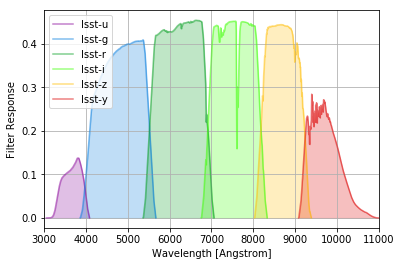

In [7]:
# LSST filters
lsst = speclite.filters.load_filters('lsst2016-*')
speclite.filters.plot_filters(lsst, wavelength_limits=(3000, 11000), legend_loc='upper left')

Load just the r,i,z filters that we need (to avoid issues with the wavelength coverage of other filters):

In [8]:
lsstGRIZ = speclite.filters.load_filters('lsst2016-g', 'lsst2016-r', 'lsst2016-i', 'lsst2016-z')

#### Blackbody spectrum

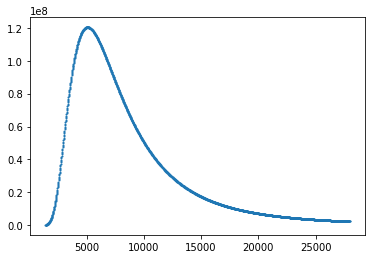

In [9]:
T = 8000
lam = np.arange(1000, 20000, 10.)
sed = blackbody(lam, T)

# z = 0.4
wlen, flux = redshift(lam, sed, 0.4)

plt.scatter(wlen, flux, s=1)
plt.show()

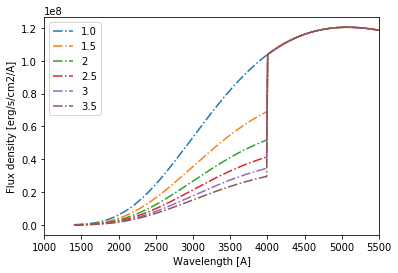

In [10]:
#plt.plot(wlen, flux, '-')
for i , d4000 in enumerate([1.0, 1.5, 2, 2.5, 3, 3.5]):
    plt.plot(wlen, apply_break(wlen, flux, 4000, d4000), '-.', label='{}'.format(d4000))
plt.xlim(1000,5500)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux density [erg/s/cm2/A]')
plt.legend(loc=2)
plt.show()

In [10]:
def calculate_mags(T, d4000, z, filters, step=0.1):
    
    z = np.asarray(z)
    T = np.asarray(T)
    d4000 = np.asarray(d4000)
    
    nz = len(z)
    nt = len(T)
    d4 = len(d4000)
    
    mags = np.empty((nt, d4, nz, len(filters)))
    
    # Calculate rest-frame wavelength range that will always cover
    # the filters after applying a redshift.
    z_min, z_max = np.percentile(z, (0, 100))
    filt_min = np.min([f.wavelength[0] for f in filters])
    filt_max = np.max([f.wavelength[-1] for f in filters])
    wlen_min = 0.9 * filt_min / (1 + z_max)
    wlen_max = 1.1 * filt_max / (1 + z_min)

    lam_rest = np.arange(wlen_min, wlen_max, step)
    
    for i, tt in enumerate(T):
        sed_rest = blackbody(lam=lam_rest, T=tt)
        for j, dd in enumerate(d4000):
            sed_rest = apply_break(lam_rest, sed_rest, 4000, dd)
            for k, zz in enumerate(z):
                lam, sed = redshift(lam=lam_rest, sed=sed_rest, z=zz)
                magnitudes = filters.get_ab_magnitudes(sed, lam)
                for m, name in enumerate(filters.names):
                    mags[i, j, k, m] = magnitudes[name][0]
    
    return mags

In [21]:
redshifts = np.arange(0, 3.5, 0.0005)
temperatures = np.arange(4000, 10100, 200)
ratios = np.arange(1.0, 5.5, 0.25)

#mags = calculate_mags(temperatures, ratios, redshifts, lsst)
#colors = mags[:, :, :, :-1] - mags[:, :, :, 1:]
#pickle.dump(colors, open('colors_z0005_t200_r25.p', 'wb'))
#pickle.dump(mags, open('mags_z0005_t200_r25.p', 'wb'))

mags = pickle.load(open('mags_z0005_t200_r25.p', 'rb'))
colors = pickle.load(open('colors_z0005_t200_r25.p', 'rb'))

#### Plot for varying redshift at a fixed temperature and ratio

In [12]:
def plot_z(it=4, id4=3):
    print('Plotting {}K, D4000 = {}'.format((temperatures[it]), ratios[id4]))
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    nmag = mags.shape[-1]
    for col in range(nmag - 1):
        ax[0].plot(redshifts, colors[it, id4, :, col], '.')
    ax[0].set_xlabel('Redshift')
    ax[0].set_ylabel('Color')
    ax[0].set_ylim(0,10)
    
    for diff in range(nmag - 2):
        ax[1].plot(colors[it, id4, :, diff], colors[it, id4, :, diff + 1], '.-')
    ax[1].set_xlabel('Color')
    ax[1].set_ylabel('Color')
    ax[1].set_ylim(0, 10)
    
    plt.tight_layout()

Plotting 4000K, D4000 = 1.0


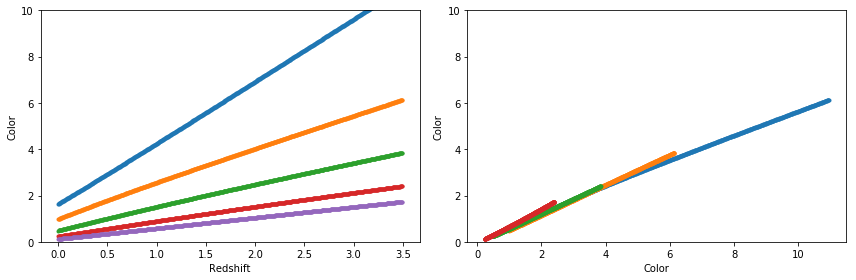

In [36]:
plot_z(it=0, id4=0)

Plotting 4000K, D4000 = 1.5


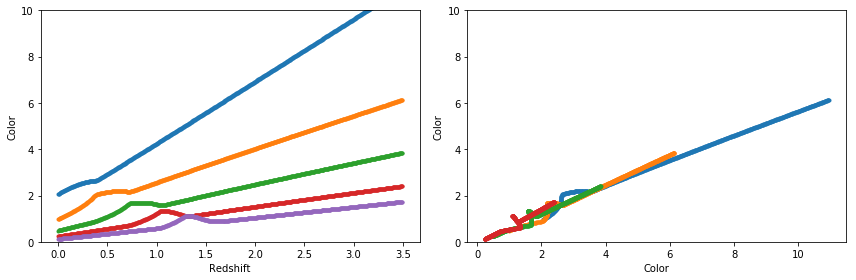

In [37]:
plot_z(it=0, id4=1)

Plotting 4000K, D4000 = 2.0


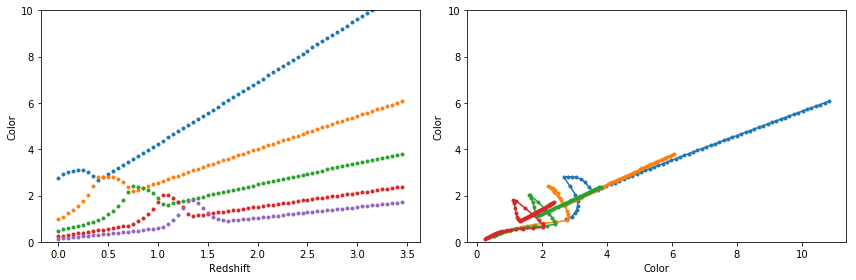

In [17]:
plot_z(it=0, id4=2)

Plotting 4000K, D4000 = 2.5


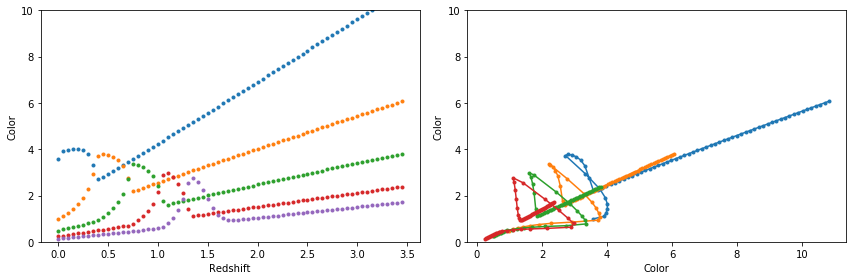

In [18]:
plot_z(it=0, id4=3)

Plotting 4000K, D4000 = 3.0


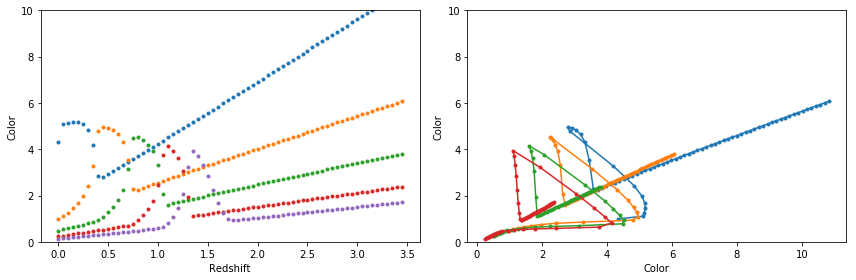

In [19]:
plot_z(it=0, id4=4)

Some notes on what we see:
- Bigger discontinuity amplitude causes large amplitude in color-z and color-color
- Tails go down in color-z plots when T increases (constant discont. amplitude); amplitude of bumps in color-z also go down, peaks seem to stay more or less in the same location
- In the color-color plots, the triangles get stretched as the temperature increases (with constant discont. amplitude)
- Increasing D4000 seems to stretch the color-color diagram horizontally and vertically.

#### Loop over first two indices and plot scatter plot of redshifts for only first two colors

In [24]:
def plot_color_color(color_index1, color_index2, color_name1, color_name2):
    nt, nr = colors.shape[:2]
    plt.figure(figsize=(10,7))
    for ii in range(nt):
        for jj in range(nr):
            plt.plot(colors[ii, jj, :, color_index1], colors[ii, jj, :, color_index2], 'k-', alpha=0.2)
            plt.scatter(colors[ii, jj, :, color_index1], colors[ii, jj, :, color_index2], c=redshifts, s=5)
    plt.xlabel(color_name1, fontsize=14)
    plt.ylabel(color_name2, fontsize=14)
    plt.colorbar(label='Redshift')
    plt.show()

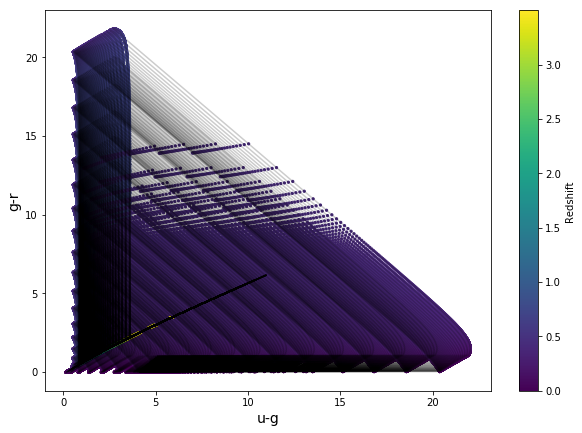

In [25]:
plot_color_color(0, 1, 'u-g', 'g-r')

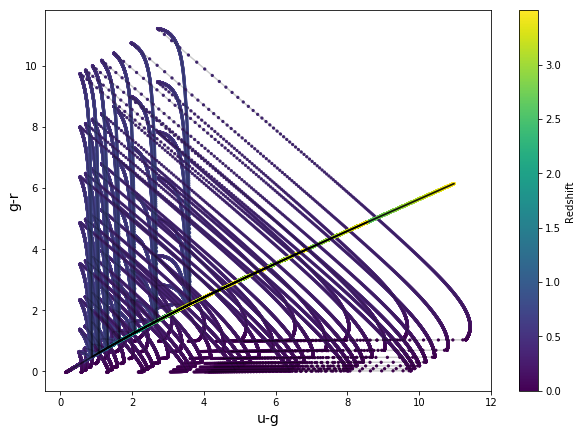

In [30]:
plot_color_color(0, 1, 'u-g', 'g-r')

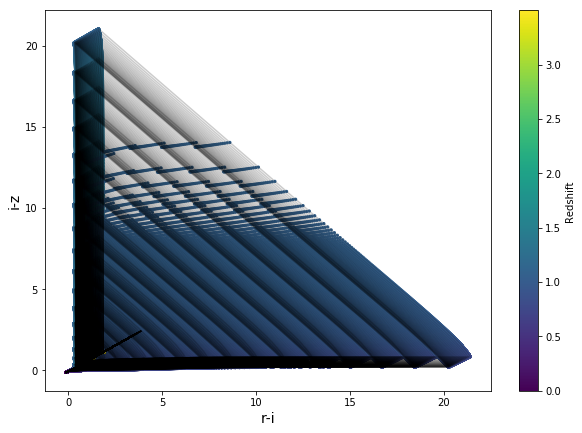

In [26]:
plot_color_color(2, 3, 'r-i', 'i-z')

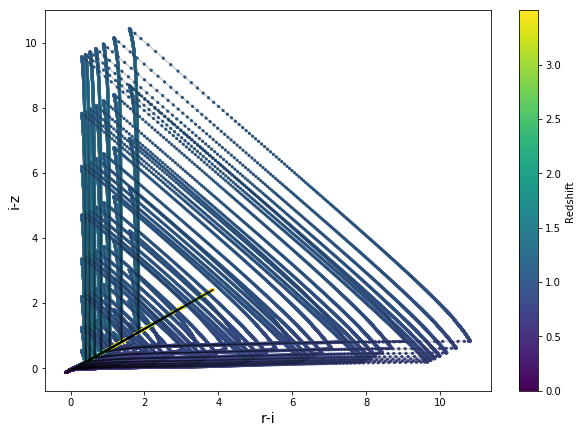

In [31]:
plot_color_color(2, 3, 'r-i', 'i-z')

#### Histogram on redshift and two colors

In [9]:
# Make table row-by-row
colors_table = Table(names=('temp', 'ratio', 'z', 'u_g', 'g_r', 'r_i', 'i_z', 'z_y'))
for tt, temp in enumerate(temperatures):
    for dd, d4000 in enumerate(ratios):
        for zz, rshift in enumerate(redshifts):
            colors_table.add_row((temp, d4000, rshift, colors[tt,dd,zz,0], colors[tt,dd,zz,1], colors[tt,dd,zz,2], 
                                 colors[tt,dd,zz,3], colors[tt,dd,zz,4]))

In [11]:
#colors_table.write('colors_table.fits')
colors_table = Table.read('colors_table.fits')

In [46]:
def get_hist(color_name1, color_name2, z_bins, color_bins):
    return(np.histogramdd([colors_table['z'].data, colors_table[color_name1].data, colors_table[color_name2].data], 
                          bins=(z_bins, color_bins, color_bins)))

def plot_hist2d(h, color_name1, color_name2):
    
    # Sum over all redshift bins to get a 24x24 grid of colors
    color_matrix = np.sum(h, axis=0)
    
    plt.figure(figsize=(10,7))
    plt.imshow(color_matrix, cmap='jet', origin='lower', interpolation='none')
    plt.xlabel(color_name1, fontsize=14)
    plt.ylabel(color_name2, fontsize=14)
    plt.xlim(0,12)
    plt.ylim(0,12)
    plt.colorbar()
    plt.show()
                  
# Redshift and color bins
z_bins = np.arange(0, 3.5, 0.00005)
color_bins = np.arange(0, 12.5, 0.4)

#### Plot distribution and get n(z) for each color bin

In [47]:
def plot_z_dist(h, color_bin1, color_bin2):
    
    color_matrix = np.sum(h, axis=0)
    
    total = color_matrix[color_bin1][color_bin2]
    plt.plot(z_midpts, h[:,color_bin1,color_bin2], '.-')
    plt.xlabel('Redshift')
    plt.ylabel('n(z)')
    plt.title('Number of points in Bin [{},{}] = {}'.format(color_bin1, color_bin2, int(total)))
    plt.show()

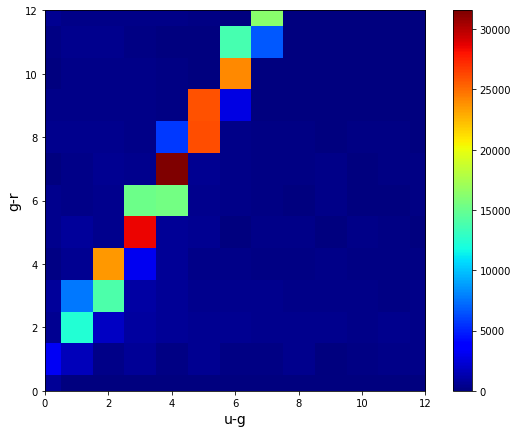

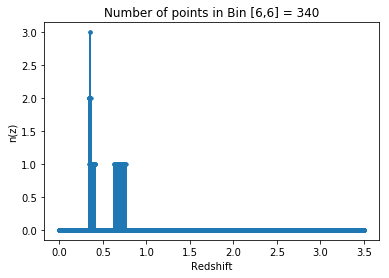

In [48]:
h, edges = get_hist('u_g', 'g_r', z_bins, color_bins)
z_midpts = (edges[0][:-1] + edges[0][1:]) / 2
plot_hist2d(h, 'u-g', 'g-r')
plot_z_dist(h, 6,6)

##### u-g vs g-r

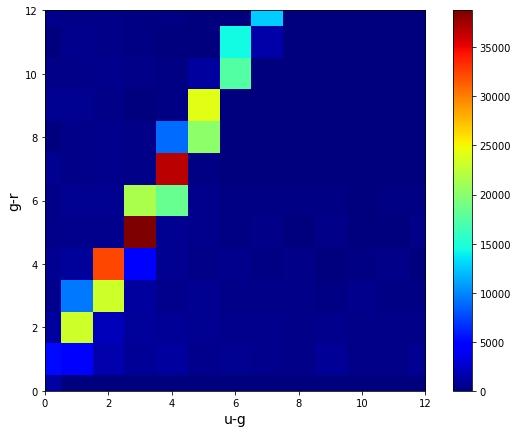

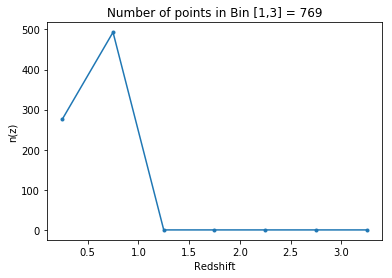

In [16]:
h, edges = get_hist('u_g', 'g_r', z_bins, color_bins)
z_midpts = (edges[0][:-1] + edges[0][1:]) / 2
plot_hist2d(h, 'u-g', 'g-r')
plot_z_dist(h, 1,3)

##### g-r vs r-i

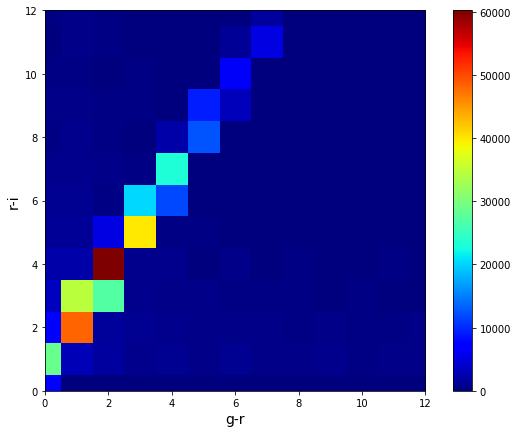

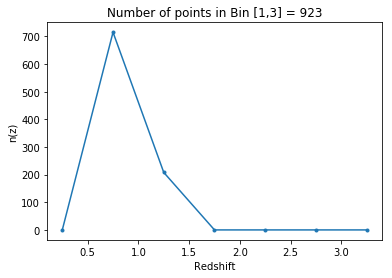

In [19]:
h, edges = get_hist('g_r', 'r_i', z_bins, color_bins)
z_midpts = (edges[0][:-1] + edges[0][1:]) / 2
plot_hist2d(h, 'g-r', 'r-i')
plot_z_dist(h, 1,3)

In [33]:
# Number of points in each redshift bin
np.sum(h, axis=(1,2))

array([52605., 63000., 63000., 63000., 63000., 63000., 63000.])

### Make color bin sizes to be on the lower end of photometric error (?)
##### Brighter colors should have lower errors
LSST SRD (https://docushare.lsstcorp.org/docushare/dsweb/Get/LPM-17) says the photometric error should be 1%. 

To propagate these errors, then: 

<center>$\delta Q = \sqrt{(min(\delta color_{1}))^{2} + (min(\delta color_{2}))^{2}}$</center>

In [9]:
colors.shape

(7, 9, 7000, 5)

In [13]:
u_g = colors[:,:,:,0]
g_r = colors[:,:,:,1]
r_i = colors[:,:,:,2]
i_z = colors[:,:,:,3]
z_y = colors[:,:,:,4]

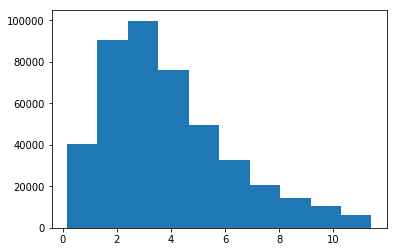

In [11]:
plt.hist(u_g.reshape(-1))
plt.show()

In [15]:
np.std(u_g), np.std(g_r), np.std(r_i), np.std(i_z), np.std(z_y)

(2.3066611484221142,
 1.6088497994834488,
 1.4085846165842835,
 1.2293153814650273,
 1.2556751449778967)